In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/finaldata/dataset/7/leftiris/eugenehol3.bmp
/kaggle/input/dataset/finaldata/dataset/7/leftiris/eugenehol1.bmp
/kaggle/input/dataset/finaldata/dataset/7/leftiris/eugenehol4.bmp
/kaggle/input/dataset/finaldata/dataset/7/leftiris/eugenehol2.bmp
/kaggle/input/dataset/finaldata/dataset/7/leftiris/eugenehol5.bmp
/kaggle/input/dataset/finaldata/dataset/7/rightiris/eugenehor3.bmp
/kaggle/input/dataset/finaldata/dataset/7/rightiris/eugenehor1.bmp
/kaggle/input/dataset/finaldata/dataset/7/rightiris/eugenehor2.bmp
/kaggle/input/dataset/finaldata/dataset/7/rightiris/eugenehor5.bmp
/kaggle/input/dataset/finaldata/dataset/7/rightiris/eugenehor4.bmp
/kaggle/input/dataset/finaldata/dataset/17/leftiris/mahskl5.bmp
/kaggle/input/dataset/finaldata/dataset/17/leftiris/mahskl2.bmp
/kaggle/input/dataset/finaldata/dataset/17/leftiris/mahskl3.bmp
/kaggle/input/dataset/finaldata/dataset/17/leftiris/mahskl1.bmp
/kaggle/input/dataset/finaldata/dataset/17/leftiris/mahskl4.bmp
/kaggle/input/d

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

def preprocess_image(image_path, is_binary=False):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))
    if is_binary:
        _, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return image

def load_data(base_dir):
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')  # Add other valid extensions if needed
    left_iris_images = []
    right_iris_images = []
    labels = []

    for person_id in os.listdir(base_dir):
        person_dir = os.path.join(base_dir, person_id)
        if os.path.isdir(person_dir):
            leftiris_dir = os.path.join(person_dir, 'leftiris')
            rightiris_dir = os.path.join(person_dir, 'rightiris')

            left_irises = []
            right_irises = []

            for img_file in os.listdir(leftiris_dir):
                if img_file.lower().endswith(valid_extensions):
                    img_path = os.path.join(leftiris_dir, img_file)
                    image = preprocess_image(img_path)
                    if image is not None:
                        left_irises.append(image)

            for img_file in os.listdir(rightiris_dir):
                if img_file.lower().endswith(valid_extensions):
                    img_path = os.path.join(rightiris_dir, img_file)
                    image = preprocess_image(img_path)
                    if image is not None:
                        right_irises.append(image)

            min_count = min(len(left_irises), len(right_irises))
            left_irises = left_irises[:min_count]
            right_irises = right_irises[:min_count]

            left_iris_images.extend(left_irises)
            right_iris_images.extend(right_irises)
            labels.extend([person_id] * min_count)

    return (np.array(left_iris_images),
            np.array(right_iris_images),
            np.array(labels))

base_dir = '/kaggle/input/dataset/finaldata/dataset'  # Adjust this path as necessary

left_iris_images, right_iris_images, labels = load_data(base_dir)

assert len(left_iris_images) == len(right_iris_images) == len(labels), "Inconsistent dataset lengths"

left_iris_images = left_iris_images.reshape(-1, 128, 128, 1).astype('float32') / 255.0
right_iris_images = right_iris_images.reshape(-1, 128, 128, 1).astype('float32') / 255.0

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

li_x_train, li_x_test, li_y_train, li_y_test = train_test_split(left_iris_images, labels_categorical, test_size=0.2, random_state=42)
ri_x_train, ri_x_test, ri_y_train, ri_y_test = train_test_split(right_iris_images, labels_categorical, test_size=0.2, random_state=42)

assert np.array_equal(li_y_train, ri_y_train), "Training labels must match across modalities"
assert np.array_equal(li_y_test, ri_y_test), "Test labels must match across modalities"

# Left iris model
left_iris_input = Input(shape=(128, 128, 1))
x1 = Conv2D(32, (3, 3), activation='relu')(left_iris_input)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Conv2D(64, (3, 3), activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Flatten()(x1)
x1 = Dense(128, activation='relu')(x1)

# Right iris model
right_iris_input = Input(shape=(128, 128, 1))
x2 = Conv2D(32, (3, 3), activation='relu')(right_iris_input)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Conv2D(64, (3, 3), activation='relu')(x2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Flatten()(x2)
x2 = Dense(128, activation='relu')(x2)

# Combine both models
combined = Concatenate()([x1, x2])
z = Dense(128, activation='relu')(combined)
z = Dense(len(label_encoder.classes_), activation='softmax')(z)

model = Model(inputs=[left_iris_input, right_iris_input], outputs=z)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit([li_x_train, ri_x_train], li_y_train, epochs=20, batch_size=32, validation_data=([li_x_test, ri_x_test], li_y_test))

loss, accuracy = model.evaluate([li_x_test, ri_x_test], li_y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

model.save('iris_biometric_recognition_model.h5')

2024-07-19 06:20:26.991374: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 06:20:26.991518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 06:20:27.215574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 126, 126,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 63, 63,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 30, 30,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 57600)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 57600)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  7,372,928 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │  7,372,928 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 45)        │      5,805 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,822,189 (56.54 MB)

 Trainable params: 14,822,189 (56.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.0134 - loss: 4.0081 - val_accuracy: 0.0444 - val_loss: 3.8993
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 753ms/step - accuracy: 0.0072 - loss: 3.7804 - val_accuracy: 0.0000e+00 - val_loss: 3.8936
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 761ms/step - accuracy: 0.0449 - loss: 3.7681 - val_accuracy: 0.0222 - val_loss: 3.9408
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 767ms/step - accuracy: 0.1607 - loss: 3.6898 - val_accuracy: 0.0222 - val_loss: 3.9665
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 749ms/step - accuracy: 0.2052 - loss: 3.4810 - val_accuracy: 0.0222 - val_loss: 3.8489
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 758ms/step - accuracy: 0.3850 - loss: 3.0856 - val_accuracy: 0.0222 - val_loss: 3.9691
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 771ms/step - accuracy: 0.4515 - loss: 2.5740 - val_accuracy: 0.2222 - val_loss: 3.4190
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 773ms/step - accuracy: 0.6585 - loss: 1.7545 - val_accuracy: 0.2889 - val_los

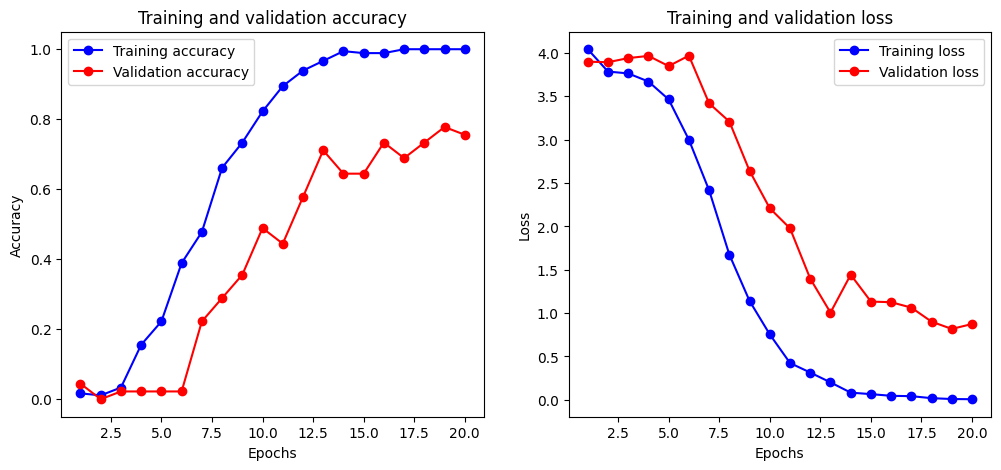

In [3]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable storing the training history returned by the `fit` method
def plot_training_history(history):
    # Extracting accuracy and loss from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Extracting the number of epochs
    epochs = range(1, len(acc) + 1)

    # Plotting training and validation accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function with the history object
plot_training_history(history)
